# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Getting Started</h1>

The basis of all of our analysis starts with the binaural signal, so we begin by importing the `Binaural` class. We'll also load up and examine our analysis settings.

In [1]:
# imports
import json
import pandas as pd
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Set width to fit the entire DataFrame

from soundscapy import Binaural
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, add_results, process_all_metrics


Set up where the data is located. In this case, we'll use the sample recordings located under the `data` folder.

In [2]:
# May need to adjust for your system
wav_folder = Path().cwd().joinpath("Field Rec")

Ensuring that Soundscapy knows exactly how loud your recordings were onsite is crucial to getting correct answers. If you used equipment such as the Head Acoustics SqoBold, and were careful about how the recordings are exported to .wav, then they may already be correctly adjusted (as ours are here). However its best to be safe and calibrate each signal to their real-world dB level. To do this, we load in a .json that contains the per-channel correct dB $L_{eq}$ level.

In [3]:
levels = wav_folder.joinpath("Levels.json")

with open("Field Rec/Levels.json") as f:
    levels= json.load(f)

levels

{'1m': {'Left': 62.573, 'Right': 62.573},
 '2m': {'Left': 58.27, 'Right': 58.27},
 '3m': {'Left': 55.83, 'Right': 55.83},
 '5m': {'Left': 53.93, 'Right': 53.93},
 '10m': {'Left': 50.43, 'Right': 50.43},
 '15m': {'Left': 50.13, 'Right': 50.13}}

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Prepping the Results Dataframe</h1>

The easiest way to organise and add the new data as it is processed is to prepare a dataframe ahead of time. We've provided a small function to convert a dictionary of calibration levels (`level`) into the properly formatted dataframe.

In [4]:
df = prep_multiindex_df(levels, incl_metric=True)
df

Leq
Recording Channel        
1m        Left     62.573
          Right    62.573
2m        Left     58.270
          Right    58.270
3m        Left     55.830
          Right    55.830
5m        Left     53.930
          Right    53.930
10m       Left     50.430
          Right    50.430
15m       Left     50.130
          Right    50.130

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Load in a Binaural Recording</h1>

Load in a binaural wav signal. We can use the `plot` function provided by the `acoustics.Signal` super-class.

c:\Users\fspintern1\AppData\Local\Programs\Python\Python311\Lib\site-packages\acoustics\_signal.py:1048: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


<Axes: title={'center': 'Signal'}, xlabel='$t$ in s', ylabel='$x$ in -'>

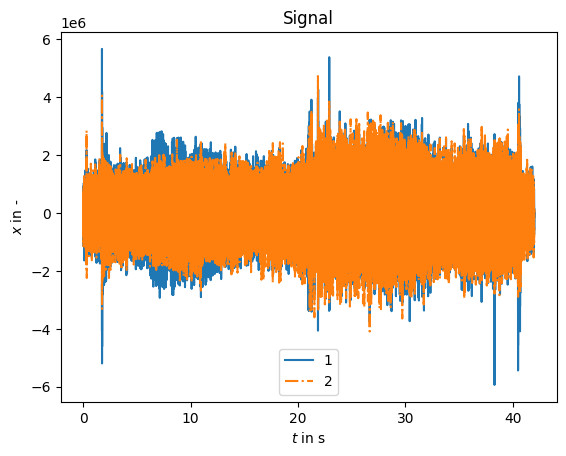

In [5]:
binaural_wav = wav_folder.joinpath("15m.wav") #we can load and Binaural Recording 
b = Binaural.from_wav(binaural_wav)
b.plot()

To ensure that the dB level is correct, and therefore any other metrics are correct, we start by calibrating the signal to precalculated levels.

In [6]:
decibel = (levels[b.recording]["Left"], levels[b.recording]["Left"])
print(f"Calibration levels: {decibel}")
b.calibrate_to(decibel, inplace=True)

Calibration levels: (50.13, 50.13)


Signal([[0.0000000e+00 2.2819379e-05 5.2484571e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 4.4556914e-06 1.3367074e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]])

Now, check it by comparing it to what we already knew were the correct levels:

<Axes: title={'center': 'Signal'}, xlabel='$t$ in s', ylabel='$x$ in -'>

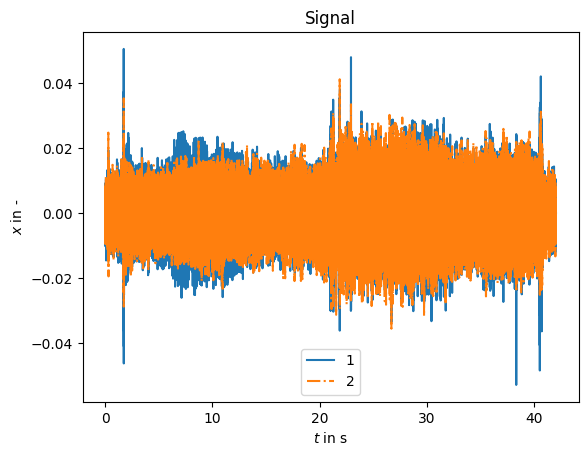

In [7]:
b.plot()

In [8]:
print(f"Predefined levels: {levels[b.recording]}")
print(f"Calculated Levels: {b.pyacoustics_metric('Leq', statistics=['avg'], as_df=False)}")

Predefined levels: {'Left': 62.573, 'Right': 62.573}
Calculated Levels: {'Left': {'Leq': 62.58017907116806}, 'Right': {'Leq': 62.57936958373111}}


In [8]:
metric = "loudness_zwtv"
stats = (5, 50, 'avg', 'max')
func_args = {
    'field_type': 'free'
}

b.mosqito_metric(metric, statistics=stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

#b.mosqito_metric("sharpness_din_from_loudness", stats, as_df=True, parallel=True, verbose=True, func_args=func_args)
# b.mosqito_metric("roughness_dw", stats, as_df=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metric: loudness_zwtv


N_5      N_50     N_avg     N_max
Recording Channel                                        
15m       Left     5.479919  4.509776  4.441168  7.813797
          Right    4.609429  3.651352  3.656647  6.538445

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Run All Functions</h1>

In [9]:
# imports
import json
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Set width to fit the entire DataFrame

from soundscapy import Binaural
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, add_results, process_all_metrics

wav_folder = Path().cwd().joinpath("Field Rec")
levels = wav_folder.joinpath("Levels.json")

with open(levels) as f:
    levels = json.load(f)
    
df = prep_multiindex_df(levels, incl_metric=False)

analysis_settings = AnalysisSettings.default()
analysis_settings["MoSQITo"]["sharpness_din_from_loudness"]["run"] = True
analysis_settings["MoSQITo"]["sharpness_din_perseg"]["run"] = False
analysis_settings["MoSQITo"]["roughness_dw"]["run"] = False

#df = b.process_all_metrics(analysis_settings, verbose=True)

# Loop through each wav file in the folder
for wav in (pbar := tqdm(list(wav_folder.glob("*.wav")))):
    recording = wav.stem
    pbar.set_description(f"Processing {recording}")
    decibel = tuple(levels[recording].values())
    b = Binaural.from_wav(wav, calibrate_to=decibel)
    df = add_results(df, b.process_all_metrics(analysis_settings, verbose=False, parallel=True)) # Process all metrics and add to results df



Processing 10m:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\fspintern1\AppData\Local\Programs\Python\Python311\Lib\site-packages\acoustics\_signal.py:1048: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)
C:\Users\fspintern1\AppData\Roaming\Python\Python311\site-packages\maad\util\miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log
C:\Users\fspintern1\AppData\Roaming\Python\Python311\site-packages\maad\util\math_func.py:445: RuntimeWarning: divide by zero encountered in log
  H = -np.sum(pmf*np.log(pmf),axis)/np.log(n)
C:\Users\fspintern1\AppData\Roaming\Python\Python311\site-packages\maad\util\math_func.py:445: RuntimeWarning: invalid value encountered in multiply
  H = -np.sum(pmf*np.log(pmf),axis)/np.log(n)
C:\Users\fspintern1\AppData\Roaming\Python\Python311\site-packages\maad\util\miscellaneous.py:358: RuntimeWarning: divide by zero encountered in log10
  y = 20*log10(x)   # take log
C:\Users\fspintern1\AppData\Roaming\Python\Pyth

MemoryError: Unable to allocate 260. MiB for an array with shape (21, 90027, 18) and data type float64

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Save the File as an Excel File</h1>

In [4]:
from datetime import datetime
df.to_excel(wav_folder.parent.joinpath("", f"AllTest_{datetime.today().strftime('%Y-%m-%d')}.xlsx"))

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Plot All Graphs</h1>

  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\fspintern1\AppData\Local\Programs\Python\Python311\Lib\site-packages\acoustics\_signal.py:1048: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)
100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


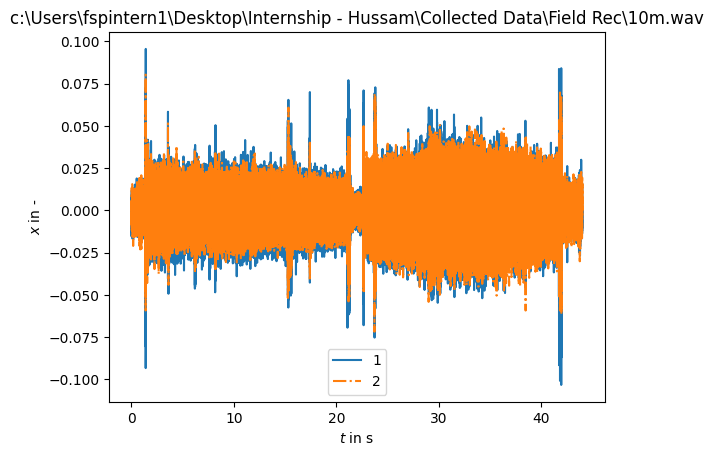

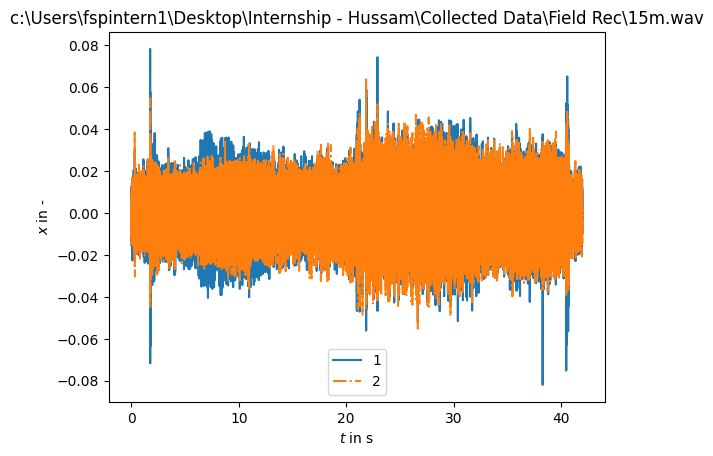

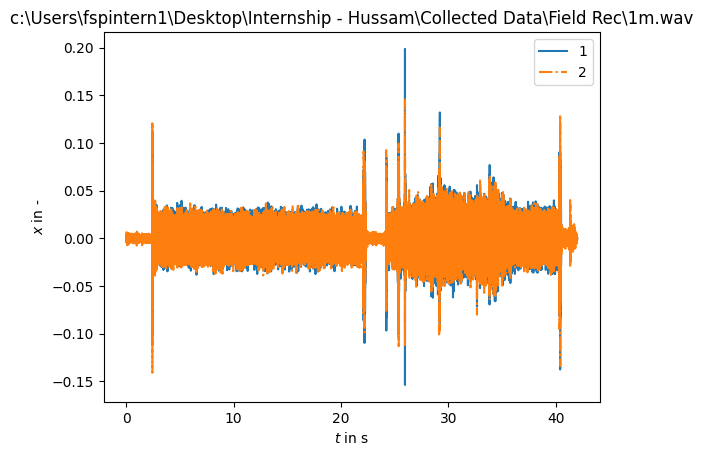

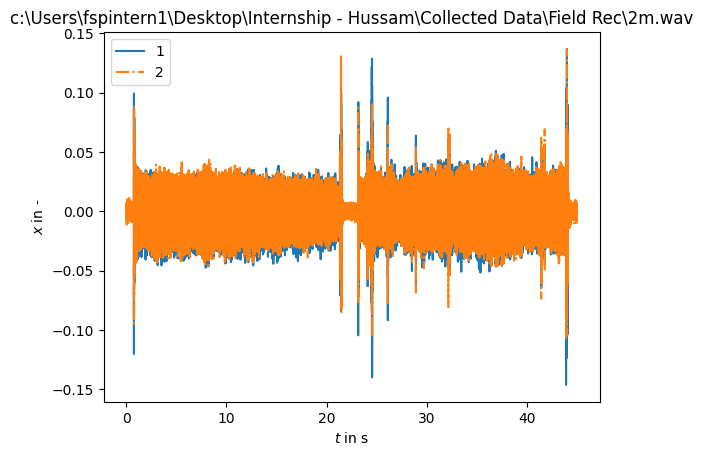

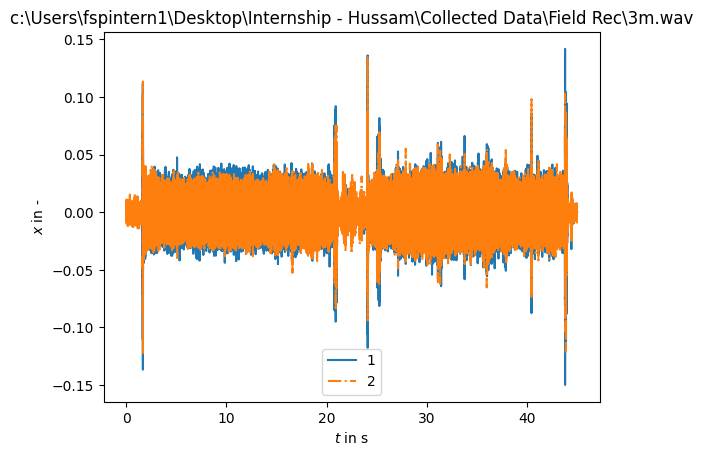

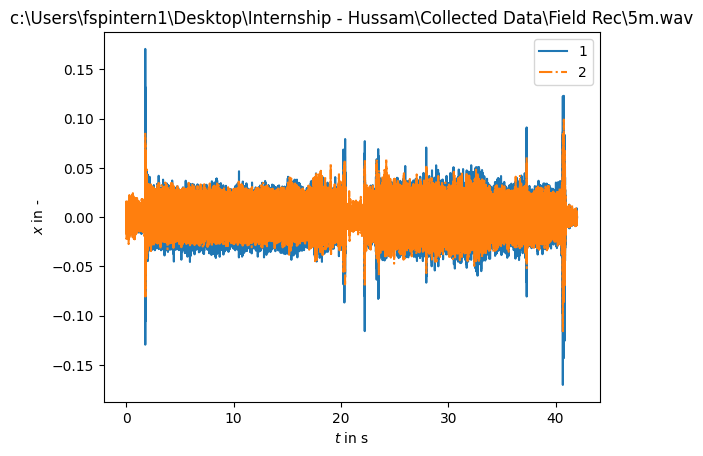

In [3]:
# imports
import pandas as pd

# Loop through each wav file in the folder
for wav in (pbar := tqdm(list(wav_folder.glob("*.wav")))):
    b = Binaural.from_wav(wav, calibrate_to=decibel)
    b.plot(title=wav)